In [1]:
import numpy as np
import time
import math
import random
import glob
from scipy import linalg as LA
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import sampler
import torchvision.transforms as T

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
float = np.vectorize(float)

def read_file(file_name):
    data = []
    with open(file_name, "r") as f:
        for line in f:
            item = line.strip().split(",")
            data.append(float(item))
    return data

In [80]:
# I = glob.glob('/content/drive/My Drive/Deep Learning Project/20-dim data (41) representation sigma=0.3/*.csv', recursive=True)
# I = glob.glob('/content/drive/My Drive/Deep Learning Project/20-dim data (41) representation old distamce/*.csv', recursive=True)
# I = glob.glob('/content/drive/My Drive/Deep Learning Project/50-dim data (41) representation sigma=0.25/*.csv', recursive=True)
# I = glob.glob('/content/drive/My Drive/Deep Learning Project/50-dim data (41) representation sigma=1000/*.csv', recursive=True)
# I = glob.glob('/content/drive/My Drive/Deep Learning Project/50-dim data (41) representation old distamce/*.csv', recursive=True)
# I = glob.glob('/content/drive/My Drive/Deep Learning Project/250-dim data (41) representation sigma=1/*.csv', recursive=True)
I = glob.glob('/content/drive/My Drive/Deep Learning Project/250-dim data (41) representation old distamce/*.csv', recursive=True)


In [5]:
r = len(I)
r

41

In [6]:
data_embed = [0] * r

for i in range(r):
    data_embed[i] = [len(np.array(read_file(I[i]))), np.array(read_file(I[i]))]

data_embed = np.array(data_embed)
#data_embed = data_embed[data_embed[:,0].argsort()]

In [7]:
X_train = [0] * r
X_test = [0] * r
y_train = [0] * r
y_test = [0] * r

for i in range(r):
    X_train[i], X_test[i], y_train[i], y_test[i] = train_test_split(np.array(data_embed[i][1]), 
                                                                np.ones(len(data_embed[i][1])), 
                                                                test_size=0.3, 
                                                                random_state=109)

In [8]:
for i in range(r):
    X_train[i] = torch.tensor(X_train[i])
    X_test[i] = torch.tensor(X_test[i])
    y_train[i] = torch.tensor(y_train[i])
    y_test[i] = torch.tensor(y_test[i])

In [9]:
X_train[0][0]

tensor([ 3.2541e-10,  6.7782e-02,  6.8058e-28,  4.8448e-07,  2.9657e-05,
         4.7325e-36,  7.6227e-04,  5.6217e-16,  1.3275e-45,  6.3676e-06,
         3.4447e-08,  2.6551e-02,  5.1362e-17,  7.6227e-04,  6.7758e-14,
        -1.0638e-19,  2.6271e-23,  5.8616e-26,  3.3738e-43,  5.1344e-53],
       dtype=torch.float64)

In [10]:
data_embed[:,0]

array([108, 150, 226, 150, 120, 747, 260, 678, 100, 196, 394, 583, 382,
       133, 173, 112, 423, 544, 407, 148, 160, 147, 154, 101, 389, 113,
       167, 106, 2124, 182, 295, 215, 146, 275, 800, 144, 207, 318, 2014,
       371, 196], dtype=object)

# 2-Layer Convolutional Network

In [11]:
def flatten(x):
    N = x.shape[0] # read in N, C, H, W
    return x.view(N, -1)

class Flatten(nn.Module):
    def forward(self, x):
        return flatten(x)

## 10-Class Classification

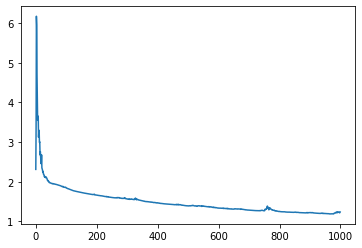

In [81]:
Start_time = time.time()

mean_train_error = 0
mean_test_error = 0
var_test_error = 0

lr_decay = 0.6
num_trials = 1
learning_rate = 0.1
Num_updates = 1000
losses = torch.zeros(num_trials, r-9, Num_updates)

for s in range(num_trials):
    
    error_train_list_all = []
    error_test_list_all = []

    Start_time_2 = time.time()

    for i in range(r-9): 

        x = torch.cat((X_train[i], X_train[i+1], X_train[i+2], X_train[i+3], 
                       X_train[i+4],X_train[i+5], X_train[i+6], X_train[i+7],
                       X_train[i+8], X_train[i+9]), 0).float()
        x = x.view(len(x), 1, x[0].shape[0])
        y = torch.cat((0 * y_train[i], y_train[i+1], 2 * y_train[i+2], 3 * y_train[i+3],
                       4 * y_train[i+4], 5 * y_train[i+5], 6 * y_train[i+6], 7* y_train[i+7],
                       8 * y_train[i+8], 9 * y_train[i+9]), 0).long()

        channel_1 = 7 # channel_1 is the dimension of hidden layer
        channel_2 = 7
        ker_1 = 5
        ker_2 = 7
        D_out = 10 # D_out is output dimension
        
        model = nn.Sequential(
                    nn.Conv1d(in_channels = 1, 
                              out_channels = channel_1, 
                              kernel_size = ker_1,
                              stride  = 1,
                              padding = 1,
                              bias = True), #shape = (3, input_dim - ker_1+1+2)
                    # nn.ReLU(),
                    # nn.LeakyReLU(0.1),
                    nn.Tanh(),

                    nn.Conv1d(in_channels = channel_1, 
                              out_channels = channel_2, 
                              kernel_size = ker_2,
                              stride  = 1,
                              padding = 1,
                              bias = True),
                    # nn.ReLU(),
                    # nn.LeakyReLU(0.01),
                    nn.Tanh(),                    
                    
                    Flatten(),
                    nn.Linear(channel_2 * (x[0][0].shape[0]-ker_2+1+2 - ker_1+1+2), D_out)
                             )

        loss_fn = torch.nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
        
        for t in range(Num_updates):
            y_pred = model(x) # of shape (N,D_out)
            loss = loss_fn(y_pred, y)
            losses[s, i, t] = loss

            #if t % 1000 == 0:
            #    print(t, loss.item())
                
            if (t+1) % 100 == 0:
                optimizer.param_groups[0]['lr'] = lr_decay * learning_rate

            optimizer.zero_grad()

            loss.backward() # Backward pass

            optimizer.step()  # Calling the step function on the Optimizer 

        X = torch.cat((X_test[i], X_test[i+1], X_test[i+2], X_test[i+3], 
                       X_test[i+4],X_test[i+5], X_test[i+6], X_test[i+7],
                       X_test[i+8], X_test[i+9]), 0).float()
        X = X.view(len(X), 1, X[0].shape[0])
        Y = torch.cat((0 * y_test[i], y_test[i+1], 2 * y_test[i+2], 3 * y_test[i+3],
                       4 * y_test[i+4], 5 * y_test[i+5], 6 * y_test[i+6], 7* y_test[i+7],
                       8 * y_test[i+8], 9 * y_test[i+9]), 0).long()
        
        Y_pred = model(X)

        error_train_list_all.append((torch.argmax(y_pred, 1) != y).sum().float()/len(y))
        error_test_list_all.append((torch.argmax(Y_pred, 1) != Y).sum().float()/len(Y))

        
    mean_train_error += np.mean(error_train_list_all)
    mean_test_error += np.mean(error_test_list_all)
    var_test_error += np.var(error_test_list_all)

mean_train_error /= num_trials
mean_test_error /= num_trials
var_test_error /= num_trials

plt.plot((torch.mean(losses[0], dim=0)).detach().numpy())
plt.show()

#### New Distance, $|Q|=20$, $\sigma=0.3$

In [59]:
print('|Q|=20,', 'sigma = 0.3,', "Number of Users: ", "41,", 'Number of Trials = ', num_trials)
print("Activation = ReLU,", "Learning Decay =", lr_decay, 
      ", Number of Updates = ", Num_updates)
Dic_1 = {}

Dic_1[1] = ["Convolutional 2-Layer", channel_1, channel_2, learning_rate, 
              np.round(mean_train_error, decimals = 4), 
              np.round(mean_test_error, decimals = 4),
              np.round(var_test_error, decimals = 4)]
    
df_1 = pd.DataFrame.from_dict(Dic_1, orient='index', 
                              columns=['Classifier', 'Channel 1', 'Channel 2', 
                                        'Learning Rate',
                                        'Train Error', 
                                       'Test Error', 'Variance Error'])
df_1

|Q|=20, sigma = 0.3, Number of Users:  41, Number of Trials =  1
Activation = ReLU, Learning Decay = 0.6 , Number of Updates =  1000


,Classifier,Channel 1,Channel 2,Learning Rate,Train Error,Test Error,Variance Error
1,Convolutional 2-Layer,7,7,0.1,0.406,0.4643,0.0089


#### Old Distance, $|Q|=20$

In [63]:
print('|Q|=20,', 'Old Distance,', "Number of Users: ", "41,", 'Number of Trials = ', num_trials)
print("Activation = ReLU,", "Learning Decay =", lr_decay, 
      ", Number of Updates = ", Num_updates)
Dic_1 = {}

Dic_1[1] = ["Convolutional 2-Layer", channel_1, channel_2, learning_rate, 
              np.round(mean_train_error, decimals = 4), 
              np.round(mean_test_error, decimals = 4),
              np.round(var_test_error, decimals = 4)]
    
df_1 = pd.DataFrame.from_dict(Dic_1, orient='index', 
                              columns=['Classifier', 'Channel 1', 'Channel 2', 
                                        'Learning Rate',
                                        'Train Error', 
                                       'Test Error', 'Variance Error'])
df_1

|Q|=20, Old Distance, Number of Users:  41, Number of Trials =  1
Activation = ReLU, Learning Decay = 0.6 , Number of Updates =  1000


,Classifier,Channel 1,Channel 2,Learning Rate,Train Error,Test Error,Variance Error
1,Convolutional 2-Layer,7,7,0.1,0.3917,0.455,0.0074


#### New Distance, $|Q|=50$, $\sigma=0.25$

In [67]:
print('|Q|=50,', 'sigma = 0.25,', "Number of Users: ", "41,", 'Number of Trials = ', num_trials)
print("Activation = ReLU,", "Learning Decay =", lr_decay, 
      ", Number of Updates = ", Num_updates)
Dic_1 = {}

Dic_1[1] = ["Convolutional 2-Layer", channel_1, channel_2, learning_rate, 
              np.round(mean_train_error, decimals = 4), 
              np.round(mean_test_error, decimals = 4),
              np.round(var_test_error, decimals = 4)]
    
df_1 = pd.DataFrame.from_dict(Dic_1, orient='index', 
                              columns=['Classifier', 'Channel 1', 'Channel 2', 
                                        'Learning Rate',
                                        'Train Error', 
                                       'Test Error', 'Variance Error'])
df_1

|Q|=50, sigma = 0.25, Number of Users:  41, Number of Trials =  1
Activation = ReLU, Learning Decay = 0.6 , Number of Updates =  1000


,Classifier,Channel 1,Channel 2,Learning Rate,Train Error,Test Error,Variance Error
1,Convolutional 2-Layer,7,7,0.1,0.399,0.4605,0.0073


#### New Distance, $|Q|=50$, $\sigma=1000$

In [71]:
print('|Q|=50,', 'sigma = 1000,', "Number of Users: ", "41,", 'Number of Trials = ', num_trials)
print("Activation = ReLU,", "Learning Decay =", lr_decay, 
      ", Number of Updates = ", Num_updates)
Dic_1 = {}

Dic_1[1] = ["Convolutional 2-Layer", channel_1, channel_2, learning_rate,
              np.round(mean_train_error, decimals = 4), 
              np.round(mean_test_error, decimals = 4),
              np.round(var_test_error, decimals = 4)]
    
df_1 = pd.DataFrame.from_dict(Dic_1, orient='index', 
                              columns=['Classifier', 'Channel 1', 'Channel 2', 
                                        'Learning Rate',
                                        'Train Error', 
                                       'Test Error', 'Variance Error'])
df_1

|Q|=50, sigma = 1000, Number of Users:  41, Number of Trials =  1
Activation = ReLU, Learning Decay = 0.6 , Number of Updates =  1000


,Classifier,Channel 1,Channel 2,Learning Rate,Train Error,Test Error,Variance Error
1,Convolutional 2-Layer,7,7,0.1,0.3961,0.4567,0.0088


#### Old Distance, $|Q|=50$

In [75]:
print('|Q|=50,', 'Old Distance,', "Number of Users: ", "41,", 'Number of Trials = ', num_trials)
print("Activation = ReLU,", "Learning Decay =", lr_decay, 
      ", Number of Updates = ", Num_updates)
Dic_1 = {}

Dic_1[1] = ["Convolutional 2-Layer", channel_1, channel_2, learning_rate, 
              np.round(mean_train_error, decimals = 4), 
              np.round(mean_test_error, decimals = 4),
              np.round(var_test_error, decimals = 4)]
    
df_1 = pd.DataFrame.from_dict(Dic_1, orient='index', 
                              columns=['Classifier', 'Channel 1', 'Channel 2', 
                                        'Learning Rate',
                                        'Train Error', 
                                       'Test Error', 'Variance Error'])
df_1

|Q|=50, Old Distance, Number of Users:  41, Number of Trials =  1
Activation = ReLU, Learning Decay = 0.6 , Number of Updates =  1000


,Classifier,Channel 1,Channel 2,Learning Rate,Train Error,Test Error,Variance Error
1,Convolutional 2-Layer,7,7,0.1,0.3916,0.4605,0.0088


#### New Distance, $|Q|=250$, $\sigma=1$

In [79]:
print('|Q|=250,', 'sigma = 1,', "Number of Users: ", "41,", 'Number of Trials = ', num_trials)
print("Activation = ReLU,", "Learning Decay =", lr_decay, 
      ", Number of Updates = ", Num_updates)
Dic_1 = {}

Dic_1[1] = ["Convolutional 2-Layer", channel_1, channel_2, learning_rate,
              np.round(mean_train_error, decimals = 4), 
              np.round(mean_test_error, decimals = 4),
              np.round(var_test_error, decimals = 4)]
    
df_1 = pd.DataFrame.from_dict(Dic_1, orient='index', 
                              columns=['Classifier', 'Channel 1', 'Channel 2', 
                                        'Learning Rate',
                                        'Train Error', 
                                       'Test Error', 'Variance Error'])
df_1

|Q|=250, sigma = 1, Number of Users:  41, Number of Trials =  1
Activation = ReLU, Learning Decay = 0.6 , Number of Updates =  1000


,Classifier,Channel 1,Channel 2,Learning Rate,Train Error,Test Error,Variance Error
1,Convolutional 2-Layer,7,7,0.1,0.3906,0.4536,0.0076


#### Old Distance, $|Q|=250$

In [83]:
print('|Q|=250,', 'Old Distance,', "Number of Users: ", "41,", 'Number of Trials = ', num_trials)
print("Activation = ReLU,", "Learning Decay =", lr_decay, 
      ", Number of Updates = ", Num_updates)
Dic_1 = {}

Dic_1[1] = ["Convolutional 2-Layer", channel_1, channel_2, learning_rate,  
              np.round(mean_train_error, decimals = 4), 
              np.round(mean_test_error, decimals = 4),
              np.round(var_test_error, decimals = 4)]
    
df_1 = pd.DataFrame.from_dict(Dic_1, orient='index', 
                              columns=['Classifier', 'Channel 1', 'Channel 2', 
                                        'Learning Rate',
                                        'Train Error', 
                                       'Test Error', 'Variance Error'])
df_1

|Q|=250, Old Distance, Number of Users:  41, Number of Trials =  1
Activation = ReLU, Learning Decay = 0.6 , Number of Updates =  1000


,Classifier,Channel 1,Channel 2,Learning Rate,Train Error,Test Error,Variance Error
1,Convolutional 2-Layer,7,7,0.1,0.4119,0.4641,0.0109


In [109]:
# I = glob.glob('/content/drive/My Drive/Deep Learning Project/20-dim data (41) representation sigma=0.3/*.csv', recursive=True)
# I = glob.glob('/content/drive/My Drive/Deep Learning Project/20-dim data (41) representation old distamce/*.csv', recursive=True)
# I = glob.glob('/content/drive/My Drive/Deep Learning Project/50-dim data (41) representation sigma=0.25/*.csv', recursive=True)
# I = glob.glob('/content/drive/My Drive/Deep Learning Project/50-dim data (41) representation sigma=1000/*.csv', recursive=True)
# I = glob.glob('/content/drive/My Drive/Deep Learning Project/50-dim data (41) representation old distamce/*.csv', recursive=True)
# I = glob.glob('/content/drive/My Drive/Deep Learning Project/250-dim data (41) representation sigma=1/*.csv', recursive=True)
I = glob.glob('/content/drive/My Drive/Deep Learning Project/250-dim data (41) representation old distamce/*.csv', recursive=True)

## Binary

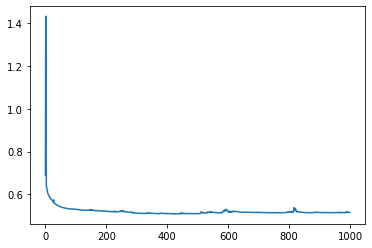

In [110]:
Start_time = time.time()

mean_train_error = 0
mean_test_error = 0
var_test_error = 0

lr_decay = 0.7
num_trials = 1
learning_rate = 0.1
Num_updates = 1000
losses = torch.zeros(num_trials, r-1, Num_updates)

for s in range(num_trials):
    
    error_train_list_all = []
    error_test_list_all = []

    Start_time_2 = time.time()

    for i in range(r-1): 
        j = i+1

        x = torch.cat((X_train[i], X_train[j]), 0).float()
        x = x.view(len(x), 1, x[0].shape[0])
        y = torch.cat((y_train[i], 
                       torch.zeros(y_train[j].size(), dtype=torch.double)), 0).long()

        channel_1 = 7 # channel_1 is the dimension of hidden layer
        channel_2 = 7
        ker_1 = 5
        ker_2 = 7
        D_out = 2 # D_out is output dimension
        
        model = nn.Sequential(
                    nn.Conv1d(in_channels = 1, 
                              out_channels = channel_1, 
                              kernel_size = ker_1,
                              stride  = 1,
                              padding = 1,
                              bias = True), #shape = (3, input_dim - ker_1+1+2)
                    nn.ReLU(),

                    nn.Conv1d(in_channels = channel_1, 
                              out_channels = channel_2, 
                              kernel_size = ker_2,
                              stride  = 1,
                              padding = 1,
                              bias = True),
                    nn.ReLU(),

                    Flatten(),
                    nn.Linear(channel_2 * (x[0][0].shape[0]-ker_2+1+2 - ker_1+1+2), D_out)
                             )
        

        loss_fn = torch.nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
        
        for t in range(Num_updates):
            y_pred = model(x) # of shape (N,D_out)
            loss = loss_fn(y_pred, y)
            losses[s, i, t] = loss

            #if t % 1000 == 0:
            #    print(t, loss.item())
                
            if (t+1) % 1000 == 0:
                optimizer.param_groups[0]['lr'] = lr_decay * learning_rate

            optimizer.zero_grad()

            loss.backward() # Backward pass

            optimizer.step()  # Calling the step function on the Optimizer 

        X = torch.cat((X_test[i], X_test[j]), 0).float()
        X = X.view(len(X), 1, X[0].shape[0])
        Y = torch.cat((y_test[i], torch.zeros(y_test[j].size(), 
                                              dtype=torch.double)), 0).long()
        
        Y_pred = model(X)

        error_train_list_all.append(int(sum(abs(torch.argmax(y_pred, axis=1)-y)))/y.shape[0])
        error_test_list_all.append(int(sum(abs(torch.argmax(Y_pred, axis=1)-Y)))/Y.shape[0])

        
    mean_train_error += np.mean(error_train_list_all)
    mean_test_error += np.mean(error_test_list_all)
    var_test_error += np.var(error_test_list_all)

mean_train_error /= num_trials
mean_test_error /= num_trials
var_test_error /= num_trials

plt.plot((torch.mean(losses[0], dim=0)).detach().numpy())
plt.show()

### New Distance, $|Q|=20$, $\sigma=0.3$

In [88]:
print('|Q|=20,', 'sigma = 0.3,', "Number of Users: ", "41,", 'Number of Trials = ', num_trials)
print("Activation = ReLU,", "Learning Decay =", lr_decay, 
      ", Number of Updates = ", Num_updates)
Dic_1 = {}

Dic_1[1] = ["Convolutional 2-Layer", channel_1, channel_2, learning_rate, 
              np.round(mean_train_error, decimals = 4), 
              np.round(mean_test_error, decimals = 4),
              np.round(var_test_error, decimals = 4)]
    
df_1 = pd.DataFrame.from_dict(Dic_1, orient='index', 
                              columns=['Classifier', 'Channel 1', 'Channel 2', 
                                        'Learning Rate',
                                        'Train Error', 
                                       'Test Error', 'Variance Error'])
df_1

|Q|=20, sigma = 0.3, Number of Users:  41, Number of Trials =  1
Activation = ReLU, Learning Decay = 0.7 , Number of Updates =  1000


,Classifier,Channel 1,Channel 2,Learning Rate,Train Error,Test Error,Variance Error
1,Convolutional 2-Layer,7,7,0.1,0.2913,0.2958,0.0174


### Old Distance, $|Q|=20$

In [92]:
print('|Q|=20,', 'Old Distance,', "Number of Users: ", "41,", 'Number of Trials = ', num_trials)
print("Activation = ReLU,", "Learning Decay =", lr_decay, 
      ", Number of Updates = ", Num_updates)
Dic_1 = {}

Dic_1[1] = ["Convolutional 2-Layer", channel_1, channel_2, learning_rate,
              np.round(mean_train_error, decimals = 4), 
              np.round(mean_test_error, decimals = 4),
              np.round(var_test_error, decimals = 4)]
    
df_1 = pd.DataFrame.from_dict(Dic_1, orient='index', 
                              columns=['Classifier', 'Channel 1', 'Channel 2', 
                                        'Learning Rate',
                                        'Train Error', 
                                       'Test Error', 'Variance Error'])
df_1

|Q|=20, Old Distance, Number of Users:  41, Number of Trials =  1
Activation = ReLU, Learning Decay = 0.7 , Number of Updates =  1000


,Classifier,Channel 1,Channel 2,Learning Rate,Train Error,Test Error,Variance Error
1,Convolutional 2-Layer,7,7,0.1,0.2928,0.3002,0.0145


### New Distance, $|Q|=50$, $\sigma=0.25$

In [96]:
print('|Q|=50,', 'sigma = 0.25,', "Number of Users: ", "41,", 'Number of Trials = ', num_trials)
print("Activation = ReLU,", "Learning Decay =", lr_decay, 
      ", Number of Updates = ", Num_updates)
Dic_1 = {}

Dic_1[1] = ["Convolutional 2-Layer", channel_1, channel_2, learning_rate,
              np.round(mean_train_error, decimals = 4), 
              np.round(mean_test_error, decimals = 4),
              np.round(var_test_error, decimals = 4)]
    
df_1 = pd.DataFrame.from_dict(Dic_1, orient='index', 
                              columns=['Classifier', 'Channel 1', 'Channel 2', 
                                        'Learning Rate',
                                        'Train Error', 
                                       'Test Error', 'Variance Error'])
df_1

|Q|=50, sigma = 0.25, Number of Users:  41, Number of Trials =  1
Activation = ReLU, Learning Decay = 0.7 , Number of Updates =  1000


,Classifier,Channel 1,Channel 2,Learning Rate,Train Error,Test Error,Variance Error
1,Convolutional 2-Layer,7,7,0.1,0.2828,0.2906,0.0166


### New Distance, $|Q|=50$, $\sigma=1000$

In [100]:
print('|Q|=50,', 'sigma = 1000,', "Number of Users: ", "41,", 'Number of Trials = ', num_trials)
print("Activation = ReLU,", "Learning Decay =", lr_decay, 
      ", Number of Updates = ", Num_updates)
Dic_1 = {}

Dic_1[1] = ["Convolutional 2-Layer", channel_1, channel_2, learning_rate,
              np.round(mean_train_error, decimals = 4), 
              np.round(mean_test_error, decimals = 4),
              np.round(var_test_error, decimals = 4)]
    
df_1 = pd.DataFrame.from_dict(Dic_1, orient='index', 
                              columns=['Classifier', 'Channel 1', 'Channel 2', 
                                        'Learning Rate',
                                        'Train Error', 
                                       'Test Error', 'Variance Error'])
df_1

|Q|=50, sigma = 1000, Number of Users:  41, Number of Trials =  1
Activation = ReLU, Learning Decay = 0.7 , Number of Updates =  1000


,Classifier,Channel 1,Channel 2,Learning Rate,Train Error,Test Error,Variance Error
1,Convolutional 2-Layer,7,7,0.1,0.2638,0.2785,0.0165


### Old Distance, $|Q|=50$

In [104]:
print('|Q|=50,', 'Old Distance,', "Number of Users: ", "41,", 'Number of Trials = ', num_trials)
print("Activation = ReLU,", "Learning Decay =", lr_decay, 
      ", Number of Updates = ", Num_updates)
Dic_1 = {}

Dic_1[1] = ["Convolutional 2-Layer", channel_1, channel_2, learning_rate, 
              np.round(mean_train_error, decimals = 4), 
              np.round(mean_test_error, decimals = 4),
              np.round(var_test_error, decimals = 4)]
    
df_1 = pd.DataFrame.from_dict(Dic_1, orient='index', 
                              columns=['Classifier', 'Channel 1', 'Channel 2', 
                                        'Learning Rate',
                                        'Train Error', 
                                       'Test Error', 'Variance Error'])
df_1

|Q|=50, Old Distance, Number of Users:  41, Number of Trials =  1
Activation = ReLU, Learning Decay = 0.7 , Number of Updates =  1000


,Classifier,Channel 1,Channel 2,Learning Rate,Train Error,Test Error,Variance Error
1,Convolutional 2-Layer,7,7,0.1,0.2967,0.3034,0.0166


### New Distance, $|Q|=250$, $\sigma=1$

In [108]:
print('|Q|=250,', 'sigma = 1,', "Number of Users: ", "41,", 'Number of Trials = ', num_trials)
print("Activation = ReLU,", "Learning Decay =", lr_decay, 
      ", Number of Updates = ", Num_updates)
Dic_1 = {}

Dic_1[1] = ["Convolutional 2-Layer", channel_1, channel_2, learning_rate,
              np.round(mean_train_error, decimals = 4), 
              np.round(mean_test_error, decimals = 4),
              np.round(var_test_error, decimals = 4)]
    
df_1 = pd.DataFrame.from_dict(Dic_1, orient='index', 
                              columns=['Classifier', 'Channel 1', 'Channel 2', 
                                        'Learning Rate',
                                        'Train Error', 
                                       'Test Error', 'Variance Error'])
df_1

|Q|=250, sigma = 1, Number of Users:  41, Number of Trials =  1
Activation = ReLU, Learning Decay = 0.7 , Number of Updates =  1000


,Classifier,Channel 1,Channel 2,Learning Rate,Train Error,Test Error,Variance Error
1,Convolutional 2-Layer,7,7,0.1,0.2915,0.2963,0.0163


### Old Distance, $|Q|=250$

In [112]:
print('|Q|=250,', 'Old Distance,', "Number of Users: ", "41,", 'Number of Trials = ', num_trials)
print("Activation = ReLU,", "Learning Decay =", lr_decay, 
      ", Number of Updates = ", Num_updates)
Dic_1 = {}

Dic_1[1] = ["Convolutional 2-Layer", channel_1, channel_2, learning_rate, 
              np.round(mean_train_error, decimals = 4), 
              np.round(mean_test_error, decimals = 4),
              np.round(var_test_error, decimals = 4)]
    
df_1 = pd.DataFrame.from_dict(Dic_1, orient='index', 
                              columns=['Classifier', 'Channel 1', 'Channel 2', 
                                        'Learning Rate',
                                        'Train Error', 
                                       'Test Error', 'Variance Error'])
df_1

|Q|=250, Old Distance, Number of Users:  41, Number of Trials =  1
Activation = ReLU, Learning Decay = 0.7 , Number of Updates =  1000


,Classifier,Channel 1,Channel 2,Learning Rate,Train Error,Test Error,Variance Error
1,Convolutional 2-Layer,7,7,0.1,0.275,0.2857,0.016
